In [1]:
import torch
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [2]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[0.5,],std=[0.5,])])

data_train=datasets.MNIST(root='D:/jupyter project/data/',transform=transform,train=True,download=False)
data_test=datasets.MNIST(root='D:/jupyter project/data/',transform=transform,train=False)

D:\anaconda\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
# shuffle = True to choose picture randomly
data_loader_train=torch.utils.data.DataLoader(dataset=data_train,batch_size=640,shuffle=True)
data_loader_test = torch.utils.data.DataLoader(dataset =data_test,batch_size = 64,shuffle = True)
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([640, 1, 28, 28])
torch.Size([3, 2402, 242])
after transpose shape: (2402, 242, 3)
[tensor(5), tensor(2), tensor(3), tensor(3), tensor(4), tensor(3), tensor(1), tensor(2), tensor(1), tensor(8), tensor(2), tensor(8), tensor(7), tensor(9), tensor(3), tensor(3)]


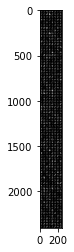

In [4]:
images,labels=next(iter(data_loader_train))
# Splicing the 64 pictures into one picture to see what the pictures look like
print(images.shape)
img=torchvision.utils.make_grid(images)
print(img.shape)
# transpose the img because imshow need a img construction of (height,weight,channel) 
# but img has a construction of (channel,height,weight)

img=img.numpy().transpose(1,2,0)

print("after transpose shape:",img.shape)

print([labels[i].data for i in range(16)])

plt.imshow(img)
plt.show()


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
import torch.nn.functional as F


class PositionEmbs(nn.Module):
    def __init__(self, num_patches, emb_dim, dropout_rate=0.1):
        super(PositionEmbs, self).__init__()
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, emb_dim))
        if dropout_rate > 0:
            self.dropout = nn.Dropout(dropout_rate)
        else:
            self.dropout = None

    def forward(self, x):
        out = x + self.pos_embedding

        if self.dropout:
            out = self.dropout(out)

        return out


class MlpBlock(nn.Module):
    """ Transformer Feed-Forward Block """

    def __init__(self, in_dim, mlp_dim, out_dim, dropout_rate=0.1):
        super(MlpBlock, self).__init__()

        # init layers
        self.fc1 = nn.Linear(in_dim, mlp_dim)
        self.fc2 = nn.Linear(mlp_dim, out_dim)
        # GELU激活函数
        self.act = nn.GELU()
        if dropout_rate > 0.0:
            self.dropout1 = nn.Dropout(dropout_rate)
            self.dropout2 = nn.Dropout(dropout_rate)
        else:
            self.dropout1 = None
            self.dropout2 = None

    def forward(self, x):

        out = self.fc1(x)
        out = self.act(out)
        if self.dropout1:
            out = self.dropout1(out)

        out = self.fc2(out)
        out = self.dropout2(out)
        return out


class LinearGeneral(nn.Module):
    def __init__(self, in_dim=(768,), feat_dim=(12, 64)):
        super(LinearGeneral, self).__init__()

        self.weight = nn.Parameter(torch.randn(*in_dim, *feat_dim))
        self.bias = nn.Parameter(torch.zeros(*feat_dim))

    def forward(self, x, dims):
        a = torch.tensordot(x, self.weight, dims=dims) + self.bias
        return a


class SelfAttention(nn.Module):
    def __init__(self, in_dim, heads=8, dropout_rate=0.1):
        super(SelfAttention, self).__init__()
        self.heads = heads
        self.head_dim = in_dim // heads
        self.scale = self.head_dim ** 0.5

        self.query = LinearGeneral((in_dim,), (self.heads, self.head_dim))
        self.key = LinearGeneral((in_dim,), (self.heads, self.head_dim))
        self.value = LinearGeneral((in_dim,), (self.heads, self.head_dim))
        self.out = LinearGeneral((self.heads, self.head_dim), (in_dim,))

        if dropout_rate > 0:
            self.dropout = nn.Dropout(dropout_rate)
        else:
            self.dropout = None

    def forward(self, x):
        b, n, _ = x.shape

        q = self.query(x, dims=([2], [0]))
        k = self.key(x, dims=([2], [0]))
        v = self.value(x, dims=([2], [0]))

        q = q.permute(0, 2, 1, 3)
        k = k.permute(0, 2, 1, 3)
        v = v.permute(0, 2, 1, 3)

        attn_weights = torch.matmul(q, k.transpose(-2, -1)) / self.scale
        attn_weights = F.softmax(attn_weights, dim=-1)
        out = torch.matmul(attn_weights, v)
        out = out.permute(0, 2, 1, 3)

        out = self.out(out, dims=([2, 3], [0, 1]))

        return out


class EncoderBlock(nn.Module):
    def __init__(self, in_dim, mlp_dim, num_heads, dropout_rate=0.1, attn_dropout_rate=0.1):
        super(EncoderBlock, self).__init__()

        self.norm1 = nn.LayerNorm(in_dim)
        self.attn = SelfAttention(in_dim, heads=num_heads, dropout_rate=attn_dropout_rate)
        if dropout_rate > 0:
            self.dropout = nn.Dropout(dropout_rate)
        else:
            self.dropout = None
        self.norm2 = nn.LayerNorm(in_dim)
        self.mlp = MlpBlock(in_dim, mlp_dim, in_dim, dropout_rate)

    def forward(self, x):
        residual = x
        out = self.norm1(x)
        out = self.attn(out)
        if self.dropout:
            out = self.dropout(out)
        out += residual
        residual = out

        out = self.norm2(out)
        out = self.mlp(out)
        out += residual
        return out


class Encoder(nn.Module):
    def __init__(self, num_patches, emb_dim, mlp_dim, num_layers=12, num_heads=12, dropout_rate=0.1,
                 attn_dropout_rate=0.0):
        super(Encoder, self).__init__()

        # positional embedding
        self.pos_embedding = PositionEmbs(num_patches, emb_dim, dropout_rate)

        # encoder blocks
        in_dim = emb_dim
        self.encoder_layers = nn.ModuleList()
        for i in range(num_layers):
            layer = EncoderBlock(in_dim, mlp_dim, num_heads, dropout_rate, attn_dropout_rate)
            self.encoder_layers.append(layer)
        self.norm = nn.LayerNorm(in_dim)

    def forward(self, x):

        out = self.pos_embedding(x)

        for layer in self.encoder_layers:
            out = layer(out)

        out = self.norm(out)
        return out


class VisionTransformer(nn.Module):
    """ Vision Transformer """

    def __init__(self,
                 image_size=(28, 28),
                 patch_size=(4, 4),
                 emb_dim=768,
                 mlp_dim=3072,
                 num_heads=12,
                 num_layers=12,
                 num_classes=10,
                 attn_dropout_rate=0.0,
                 dropout_rate=0.1,
                 feat_dim=None):
        super(VisionTransformer, self).__init__()
        h, w = image_size

        # embedding layer
        fh, fw = patch_size
        gh, gw = h // fh, w // fw
        num_patches = gh * gw
        self.embedding = nn.Conv2d(1, emb_dim, kernel_size=(fh, fw), stride=(fh, fw))
        # class token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, emb_dim))

        # transformer
        self.transformer = Encoder(
            num_patches=num_patches,
            emb_dim=emb_dim,
            mlp_dim=mlp_dim,
            num_layers=num_layers,
            num_heads=num_heads,
            dropout_rate=dropout_rate,
            attn_dropout_rate=attn_dropout_rate)

        # classfier
        self.classifier = nn.Linear(emb_dim, num_classes)

    def forward(self, x):
        emb = self.embedding(x)  # (n, c, gh, gw)
        emb = emb.permute(0, 2, 3, 1)  # (n, gh, hw, c)
        b, h, w, c = emb.shape
        emb = emb.reshape(b, h * w, c)

        # prepend class token
        cls_token = self.cls_token.repeat(b, 1, 1)
        emb = torch.cat([cls_token, emb], dim=1)

        # transformer
        feat = self.transformer(emb)

        # classifier
        logits = self.classifier(feat[:, 0])
        return logits


In [9]:
vit1 = VisionTransformer(num_layers=2)
#if torch.cuda.is_available():
 #   vit1 = vit1.cuda()

# CrossEntropy = softmax + log + NLL loss

loss_func = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(vit1.parameters(),lr=0.01)


In [10]:
def train1():
    x_train, y_train = next(iter(data_loader_train))
    #x_train = x_train.to(device)
    #y_train = y_train.to(device)
    y_hat = vit1(x_train)
    loss = loss_func(y_hat, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print('epoch %d, loss %.4f' % (epoch + 1, loss))
    return loss

In [11]:
def test1():
    correct = 0
    x_test, y_test = next(iter(data_loader_test))
   # x_test = x_test.to(device)
   # y_test = y_test.to(device)
    outputs = vit1(x_test)
    _, predict = torch.max(outputs.data, dim=1)
    correct += torch.sum(predict == y_test.data)
    correct = correct.detach().cpu().numpy()
    print("correct rate = ",100 * correct/len(data_test))
    return 100 * correct/len(data_test) *0.01

epoch 1, loss 2.3884
correct rate =  0.09
epoch 2, loss 2.6307
correct rate =  0.18
epoch 3, loss 2.6538
correct rate =  0.09
epoch 4, loss 2.8254
correct rate =  0.11
epoch 5, loss 2.4483
correct rate =  0.25
epoch 6, loss 2.2984
correct rate =  0.22
epoch 7, loss 2.5098
correct rate =  0.19
epoch 8, loss 2.3258
correct rate =  0.3
epoch 9, loss 1.8711
correct rate =  0.26
epoch 10, loss 1.6546
correct rate =  0.15


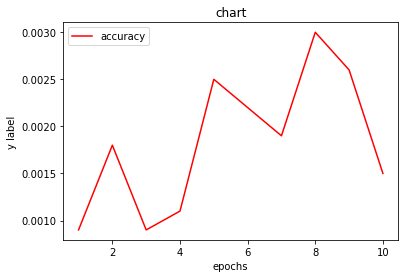

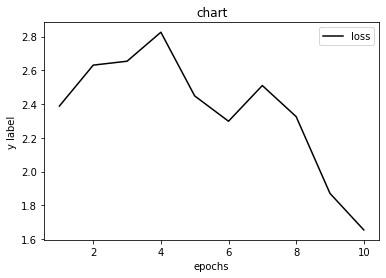

In [12]:
lss = []
acc = []
epochs = []
for epoch in range(10):
    epochs.append(epoch+1)
    ls = train1();
    ac = test1();
    l_tmp = ls.detach().cpu().numpy()
    lss.append(l_tmp)
    acc.append(ac);
    
plt.plot(epochs,acc,color='r',label='accuracy')  
plt.xlabel('epochs')    
plt.ylabel('y label')   
plt.title("chart")      
plt.legend()   
plt.show()

plt.plot(epochs,lss,color=(0,0,0),label='loss')
plt.xlabel('epochs')    
plt.ylabel('y label')   
plt.title("chart")      
plt.legend()            
plt.show()